In the past few months, during a job interview, I have been given a take home assessment about graph machine learning.  
The dataset I had to work on was the <a href="https://paperswithcode.com/dataset/ppi" target="_blank">PPI dataset</a> (with few changes from its original version).  
Being a Python and Tensorflow user, I decided to tackle it using the framework <a href="https://graphneural.network/" target="_blank">Spektral</a>[<sup>1</sup>](#fn1) by <a href="https://danielegrattarola.github.io/" target="_blank">Daniele Grattarola</a>, and since apparently there are not many examples of similar applications on PPI out there, I though of sharing my code.
<!-- TEASER_END -->

<h3><strong>Table of contents:</strong></h3>

1. [Description of the task](#task-desc)
2. [My Approach](#approach)
3. [Required modules](#modules)
4. [Quick EDA](#eda)
5. [Text processing and features extraction](#txt)
6. [Creating Spektral graph datasets](#spektral-ds)
7. [Implementing the GAT model](#gat)
8. [Training and evaluating the model](#train)


<h2><strong>Description of the task</strong></h2> <a class="anchor" id="task-desc"></a>  

**The dataset**  
The provided dataset was a modification of a protein-protein interaction dataset described in <a href="https://arxiv.org/abs/1707.04638" target="_blank"><em>Zitnik & Leskovec, 2017</em></a>[<sup>2</sup>](#fn2), where protein interactions are modelled as graph edges. 
The data consisted of train, test and validation sets, each of which was made of 4 files: 
- `SET_feats.npy`: a numpy matrix where each row is a numerical feature vector corresponding to a graph node
- `SET_labels.npy`: a numpy matrix where each row is a K-hot vector of labels for each graph node
- `SET_graph_ids.npy`: a numpy array where each element value indicates the graph ID to which the given node belongs.
- `SET_graph.json` : a json file containing information about all graphs in this data set (with fields regarding `nodes` and `links`) 

**Changes to the original dataset**

- The `nodes` field in `SET_graph.json` contains a list of dictionaries corresponding to each node. Each node has a `text` field, where arbitrary text data extracted from StackOverflow has been appended. 
- Under the `links` field, a list of `source` and `target` pairs representing graph edges has been added.  

**The task**  
The task involved the implementation of *"a machine learning algorithm to train on this dataset"*. Since the text appended to each node information does not have predictive abilities for the graph, it was recommended not to try generating good quality predictions, but to focus on researching the most appropriate approach for this type of dataset, where graph node features contain text.

<h2><strong>My approach</strong></h2> <a class="anchor" id="approach"></a>  

After a first look at the dataset, I concluded that I was dealing with <a href=" https://en.wikipedia.org/wiki/Multi-label_classification" target="_blank"><em><strong>multi-label classification</strong></em></a>, and started doing some research on similar tasks. I found that an <a href="https://mariani.ai/posts/a-quick-introduction-to-graph-neural-networks/#transductive-inductive" target="_blank"><em>inductive approach</em></a> could be used; specifically, the paper <a href="https://arxiv.org/pdf/1710.10903.pdf" target="_blank"><em>Graph Attention Networks</em></a>[<sup>3</sup>](#fn3) describes how the attention mechanism is performed across nodes and edges outperforming the <a href="https://arxiv.org/pdf/1706.02216.pdf" target="_blank"><em>GraphSAGE approach</em></a>[<sup>4</sup>](#fn4) on the PPI dataset (the original one, without any addition).  
Hence, this is the architecture I have chosen for this exercise. About the text features, since they were not giving any additional predictive power I just thought of processing the data with simple <a href="https://en.wikipedia.org/wiki/Bag-of-words_model" target="_blank">Bag of Words</a> (BOW) approach and appending the extracted features to the node vectors.

<h2><strong>Required modules</strong></h2> <a class="anchor" id="modules"></a>  

I work mainly in Python, so these are the main libraries that I have been using for this exercise:
- **networkx** for some data exploration and for creating the ajaciency matrices
- **tensorflow** as a main deep learning framework
- **nltk** for text processing(in particular, `nltk.tokenize.word_tokenize` for tokenization, `nltk.stem.snowball.SnowballStemmer` for stemming and `nltk.corpus.stopwords` for a reliable list of stop words to remove during preprocessing)
- **scikit learn** (mainly for using the `sklearn.feature_extraction.text.CountVectorizer`)
- **spektral** as I mentioned in the intro
- and obviously **numpy**

You can have a look at the main modules imported from tensorflow and spektral below:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed

from spektral.data import Dataset, Graph
from spektral.data import DisjointLoader
from spektral.layers import GATConv
from spektral.transforms import LayerPreprocess

from tensorflow_addons.metrics import F1Score

<h2><strong>Quick EDA</strong></h2> <a class="anchor" id="eda"></a>  

Here's the script used for loading the datasets provided, and some quick exploration of the data available.

In [3]:
#looading training data
train_graph_id = np.load('data/train_graph_id.npy')
train_feats = np.load('data/train_feats.npy')
train_labels = np.load('data/train_labels.npy')

#loading validation data
valid_graph_id = np.load('data/valid_graph_id.npy')
valid_feats = np.load('data/valid_feats.npy')
valid_labels = np.load('data/valid_labels.npy')

#loading test data
test_graph_id = np.load('data/test_graph_id.npy')
test_feats = np.load('data/test_feats.npy')
test_labels = np.load('data/test_labels.npy')

#loading graph info
def load_json(filepath):
    with open(filepath) as file:
        output = json.load(file)
        
    return output

train_graph = load_json('data/train_graph.json')
valid_graph = load_json('data/valid_graph.json')
test_graph = load_json('data/test_graph.json')

The dataset is split into train, validation and test set; each of them contains the following:
- 44906 nodes over 20 graphs in the training set
- 6514 nodes over 2 graphs in the validation set
- 5524 nodes over 2 graphs in the test set  

Each node is represented by a 50-dimensional feature vector.  
The labels have a shape like the one shown below.

In [6]:
train_labels[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

Each element of `['nodes']` is a dictionary containing `'id'` and `'text'` for a the corresponding **node**, and this is an example of what the text added to the nodes looks like:

In [12]:
train_graph['nodes'][0]

{'id': 0,
 'text': 'How do I fill a DataSet or a DataTable from a LINQ query resultset ?'}

On the other hand, each element of `['links']` is a dictionary containing `'source'` and `'target'` information of an **edge**.

In [14]:
train_graph['links'][0]

{'source': 0, 'target': 372}

<h2><strong>Text processing and features extraction</strong></h2> <a class="anchor" id="txt"></a>  

Since predictive results were not the point of the exercise as the texts associated with each node were basically thrown randomly, I opted for a very quick and easy approach: I concatenated the features coming from the text data with the provided PPI node features. 
For doing that, I have performed the following steps:
- Cleaning the text data removing punctuation, stop words and some symbol characters, and performing stemming

In [18]:
#replace symbols with a space
re_replace_by_space = re.compile('[/(){}\[\]\|@,;]') 

#symbols to remove
re_remove = re.compile('[^0-9a-z #+_]') 

#stopwords
stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer('english')

def text_prepare(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    
    #perform replace and delete operations
    text = re_replace_by_space.sub(" ", text)
    text = re_remove.sub("", text)
    
    #remove stopwords and apply stemmer
    text = " ".join([stemmer.stem(w) for w in text.split() \ 
                     if w not in stop_words]) 
    
    return text

- Performing BOW with `CountVectorizer`

In [19]:
#CountVectorizer - fitting and performing transform on training data
train_corpus = [text_prepare(n['text']) for n in train_graph['nodes']]

ctv = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)
train_ctv_feats = ctv.fit_transform(train_corpus)

# transforming valid data
valid_corpus = [text_prepare(n['text']) for n in valid_graph['nodes']]
valid_ctv_feats = ctv.transform(valid_corpus)

# transforming test data
test_corpus = [text_prepare(n['text']) for n in test_graph['nodes']]
test_ctv_feats = ctv.transform(test_corpus)

- Performing dimensionality reduction step using <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition" target="_blank">Singular Value Decomposition</a>. This step is done to avoid concatenating a matrix that would result too sparse leading the model to overfit

In [21]:
#perform dimensionality reduction with latent semantics analysis
svd = decomposition.TruncatedSVD(n_components = 15)
train_ctv_feats_reduced = svd.fit_transform(train_ctv_feats)

#reduce validation and test set with the SVD fit on the training part
valid_ctv_feats_reduced = svd.transform(valid_ctv_feats)
test_ctv_feats_reduced = svd.transform(test_ctv_feats)

- Concatenating the provided node feature vectors with the resulting text feature vectors

In [23]:
#concatenating provided node feats with the text feats
train_feats_conc = np.concatenate((train_feats, train_ctv_feats_reduced), 
                                  axis = 1)
valid_feats_conc = np.concatenate((valid_feats, valid_ctv_feats_reduced), 
                                  axis = 1)
test_feats_conc = np.concatenate((test_feats, test_ctv_feats_reduced), 
                                 axis = 1)

Please note: to avoid forward looking, both `CountVectorizer` and `TruncatedSVD` have been fit on training data only, and then used for transforming training, validation and test portion. 

<h2><strong>Creating Spektral graph datasets</strong></h2> <a class="anchor" id="spektral-ds"></a>  

The PPI dataset is <a href = "https://graphneural.network/datasets/" target="_blank"> readily available within Spektral</a>, but since I had to deal with a modified version of it, I thought of taking the chance to learn a bit more about how to create a graph dataset by myself.  
  
I have used the <a href = "https://graphneural.network/creating-dataset/" target = "_blank">`spektral.data.Dataset`</a> class to create three custom datasets: one for training, one for validation and one for testing.   
Spektral has three different <a href = "https://graphneural.network/data-modes/" target="_blank">data modes</a> that can be used to model the graph data, depending on use case, scalability and modelling requirements: *single mode*, *disjoint mode* and *batch mode*.  
I am not covering them in detail since the original documentation linked above describes them clearly and it is very useful for having a deeper understanding.  
I used the <a href="https://graphneural.network/data-modes/#disjoint-mode" target="_blank">**Disjoint Mode**</a>, which is a clever solution for creating a single adjaciency matrix that includes all the graphs in a given set (training, validation or testing) in its diagonal, and to use all of them for training and evaluation sessions. 

According with the documentation, the `Dataset` class essentially needs the following:
- a `read` method that is called at every instantiation of the dataset and must return a list of `spektral.data.Graph`
- an `__init__` method that calls both `read` (and also `download`, that I am not covering here). 

To override the dataset initialization, we can call `super().__init__()` somewhere in your implementation (usually as the last line).

In [ ]:
class myCustomDataset(Dataset):
    """
    The graphs dataset
    """
    def __init__(self, graph_info, feats, labels, graphs_id, **kwargs):
        """
        Attr:
        - graph_info: a dictionary containing graph information 
                      in the form
                      {'directed': bool, 
                      'multigraph': bool, 
                      'graph': [], 
                      'nodes':[{},{}], 'links':[{},{}]}
        - feats: the feature vectors for each node
        - labels: the labels for each node
        - graphs_id: the graph masks, indicating what graph 
                     each node belongs to
        """
        
        self.feats = np.array(feats)
        self.labels = np.array(labels)
        self.graphs_id = np.array(graphs_id)
        
        #adding corresponding graph id to the node info
        for n_idx, n in enumerate(graph_info['nodes']):
            n['graph_id'] = graphs_id[n_idx]
        
        self.graph_info = graph_info
        self.nodes = np.array([n['id'] for n in self.graph_info['nodes']])
        
        #graph to node correspondence dict
        g_to_n_dict = {}
        nodeslab = np.arange(self.labels.shape[0])
        
        for i in set(self.graphs_id):
            g_to_n_dict[i] = set(nodeslab[self.graphs_id == i])    
        self.__g_to_n_dict = g_to_n_dict
        
        #node to graph correspondence dict
        n_to_g_dict = dict(zip(nodeslab, 
                               [nn['graph_id'] \
                                for nn in self.graph_info['nodes']]))
        self.__n_to_g_dict = n_to_g_dict

        super().__init__(**kwargs)
        
    def read(self):
        """
        Method returning the list of graphs
        """
        
        output = [] #this will be the list of graphs to output
        
        for gid in set(self.graphs_id):
            
            filt = self.graphs_id == gid #selection filter
            
            n = self.nodes[filt] #nodes belonging to current graph
            
            x = self.feats[filt] #features belonging to current graph
            y = self.labels[filt] #labels belonging to current graph
            
            #creating a networkx graph for extracting the adjacency matrix
            g_nx = nx.DiGraph()
            g_nx.add_nodes_from(n)
            
            edges_list = [(t['source'], t['target']) \
                          for t in self.graph_info['links'] \
                          if self.__n_to_g_dict[t['source']] == gid]
            g_nx.add_edges_from(edges_list)
            
            adj = nx.adjacency_matrix(g_nx) #current graph's adj matrix
            
            output.append(Graph(x = x, a = adj, y = y))
            
        return output

After creating the dataset class, I was able to create custom Spektral datasets for all the three phases:

In [ ]:
#training
tr_dataset = myCustomDataset(train_graph,
                         train_feats_conc,
                         train_labels,
                         train_graph_id, 
                             transforms=[LayerPreprocess(GATConv)])

#validation
val_dataset = nPlanDataset(valid_graph,
                         valid_feats_conc,
                         valid_labels,
                         valid_graph_id, 
                           transforms=[LayerPreprocess(GATConv)])

#testing
te_dataset = nPlanDataset(test_graph,
                         test_feats_conc,
                         test_labels,
                         test_graph_id, 
                          transforms=[LayerPreprocess(GATConv)])

<h2><strong>Implementing the GAT model</strong></h2> <a class="anchor" id="gat"></a>  

The model's architecture has been built using the <a href="https://graphneural.network/layers/convolution/#gatconv" target="_blank">Spektral implementation of GAT convolutional layers</a>. As mentioned, I tried to recreate the inductive approach and the model's settings implemented in <a href="https://arxiv.org/pdf/1710.10903.pdf" target="_blank"><em>Graph Attention Networks</em></a>[<sup>3</sup>](#fn3); below you can see a summary of my final choices:
- 2 GAT layers with 4 attention heads computing 128 features (the original paper states actually 256 features) followed by ELU non-linearity
- 1 final GAT layer with 6 attention heads which computes the multi-label classification output consisting of a 121 long vector.
- Only the intermediate layer has been provided with a dropout value to perform the skip-connection regularization
- I used a batch size of 2 graphs
- I used <a href="https://keras.io/api/optimizers/adam/" target="_blank">Adam optimizer</a> with a learning rate of 0.005, optimizing on binary cross-entropy and setting up an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping" target="_blank">`EarlyStopping` stopping callback</a> based on <a href="https://en.wikipedia.org/wiki/F-score" target="_blank">F1 score</a> with micro-averaging, calculated on the validation set.

Here's the function used to create the model's architecture to train.

In [28]:
def create_GAT():
    """
    This function creates a Graph Attention Network (GAT)
    """
    
    ###############
    # Parameters
    ###############
    channels = 128  # no. of channels in each head of the first GAT layer
    n_attn_heads = 4  # no. of att. heads in first and second GAT layer
    n_attn_heads_final = 6 # no. of att. heads in output GAT layer
    mid_layer_skip = 0.6  # skip connection dropout for middle GAT layer
    learning_rate = 5e-3  # Learning rate
    
    #############
    #Optimizer
    #############
    optimizer = Adam(learning_rate = learning_rate)
    
    ###############
    #Architecture
    ###############
    
    #Inputs
    x_in = Input(shape=(tr_dataset.n_node_features,), 
                 name = 'node_features_input')
    
    a_in = Input(shape = (None,), sparse=True, 
                 name = 'adj_input')
    
    i_in = Input(shape = (), 
                 name = 'dummy_idx_input') #dummy input for graph index

    #GAT layer 1
    gc_1 = GATConv(
        channels,
        attn_heads=n_attn_heads,
        add_self_loops = False, #self-loops are already in the dataset
        concat_heads=True,
        dropout_rate = 0,
        activation="elu",
        kernel_initializer='glorot_uniform',
        name = 'GAT_1'
    )([x_in, a_in])
    
    #GAT layer 2
    gc_2 = GATConv(
        channels,
        attn_heads = n_attn_heads,
        add_self_loops = False, #self-loops are already in the dataset
        concat_heads = True,
        dropout_rate = mid_layer_skip,
        activation = "elu",
        name = 'GAT_2'
    )([gc_1, a_in])
    
    #GAT layer 3 - output
    gc_3 = GATConv(
        train_labels.shape[1], #this is the output layer
        attn_heads=n_attn_heads_final,
        add_self_loops = False, #self-loops are already in the dataset
        concat_heads=False,
        dropout_rate = 0,
        activation= "sigmoid", # "softmax",
        name = 'GAT_final'
    )([gc_2, a_in])
    
   #############
    #Compiler
    ############
    model = Model(inputs=[x_in, a_in, i_in], outputs=gc_3)
    
    model.compile(
        optimizer=optimizer,
        loss= BinaryCrossentropy(),
        weighted_metrics=["acc", F1Score(num_classes = 1, 
                                         average = 'micro', 
                                         threshold = 0.5)],
    )
    
    return model


We just need to call the function assigning the model object returned to a variable:

In [29]:
# Build model
model = create_GAT()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_features_input (InputLaye  [(None, 65)]        0           []                               
 r)                                                                                               
                                                                                                  
 adj_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 GAT_1 (GATConv)                (None, 512)          34816       ['node_features_input[0][0]',    
                                                                  'adj_input[0][0]']              
                                                                                              

<h2><strong>Training and evaluating the model</strong></h2> <a class="anchor" id="train"></a>  

To feed the model with the data, we need to use the <a href="https://graphneural.network/loaders/" target="_blank">`spektral.data.Loaders`</a>, that iterate over a dataset yielding batches of graphs for training the model.  
Having used the *disjoint mode*, it was pretty obvious to use the <a href="https://graphneural.network/loaders/#disjointloader" target="_blank">`DisjointLoader`</a> as shown below:

In [30]:
#Loading train, valid and test datasets into Spektral disjoint loaders
tr_loader = DisjointLoader(tr_dataset, 
                           node_level = True, batch_size = 2)

val_loader = DisjointLoader(val_dataset, 
                            node_level = True, batch_size = 2)

te_loader = DisjointLoader(te_dataset, 
                           node_level = True, batch_size = 2)

Running the training is pretty much standard tensorflow `fit` procedure, being careful in specifying batch steps in a way that allows tensorflow to separate graphs from each other:

In [ ]:
set_seed(42)

epochs = 10000  # Number of training epochs
patience = 100  # Patience for early stopping

warnings.filterwarnings('ignore')

# Train model
history = model.fit(tr_loader.load(),
          steps_per_epoch=tr_loader.steps_per_epoch,
          validation_data = val_loader.load(),
          validation_steps = val_loader.steps_per_epoch,
         epochs=epochs,
         callbacks=[EarlyStopping(patience=patience, 
                                  restore_best_weights=True, 
                                  mode = 'max', 
                                  monitor = 'val_f1_score')]
)

warnings.resetwarnings()

Comparing training and validation loss and f1 score, we can see that the model manages to learn quite nicely.

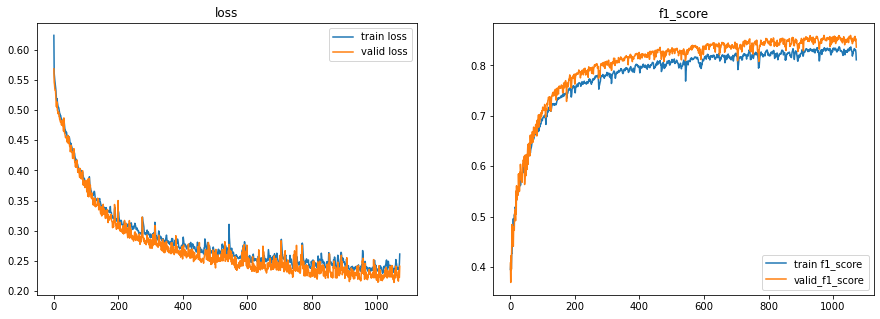

In [32]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(history.history['loss'], label = 'train loss')
ax[0].plot(history.history['val_loss'], label = 'valid loss')
ax[0].set_title('loss')
ax[0].legend()

ax[1].plot(history.history['f1_score'], label = 'train f1_score')
ax[1].plot(history.history['val_f1_score'], label = 'valid_f1_score')
ax[1].set_title('f1_score')
ax[1].legend()

After being saved, the model has been tested on the provided test set using the code snippet below, and achieving an F1 score of 0.88, which is close to what observed during training and validation.  
I hope this article was useful, I personally enjoyed this task very much as it allowed me to do some applied work on graph neural networks.

<h2><strong>References</strong></h2> <a class="anchor" id="references"></a>

<p id="fn1">[1] Grattarola D., Alippi C., <a href="https://arxiv.org/pdf/2006.12138.pdf">Graph Neural Networks in TensorFlow and Keras with Spektral</a>, 2020.</p>
<p id="fn2">[2] Zitnik & Leskovec, 2017, et al., <a href="https://distill.pub/2021/gnn-intro/">Predicting multicellular function through multi-layer tissue networks</a>, Bioinformatics 2017, 33 (14): i190-i198.</p>
<p id="fn3">[3] Veličković P., et al., <a href="https://arxiv.org/pdf/1710.10903.pdf">Graph Attention Networks</a>, 2018.</p>
<p id="fn4">[4] Hamilton W. L., Ying R., Leskovec Y., <a href="https://arxiv.org/pdf/1706.02216.pdf">Inductive Representation Learning on Large Graphs</a>, 2017.</p>